# Memory Usage and Connections

Since we do not place any constraints on memory usage or number of connections for each mule, we want to be able to see how much memory and how many connections each mule has at any one time.

## Memory Usage

We start with amount of memory that data occupies on mules at any time.

In [26]:
# Import libraries.
import csv
import math
import numpy as np
import pandas as pd
from matplotlib import cm as cm
from matplotlib import pyplot as plt

In [18]:
schedule_file = 'prob_data/random_uploads/schedule.csv'

with open(schedule_file, 'r') as f:
    reader = csv.DictReader(f)
    for row in reader:
        num_mules = int(row['num_mules'])
        t_grain = float(row['advertisement_period'])
        break

schedule_df = pd.read_csv(schedule_file, skiprows=3)
packet_size = schedule_df.at[0,'data_length']
schedule_df.head()


,sensor_id,mule_id,sample_time,pickup_time,batch_time,data_length
0,697,0,0.0,1.501024,122,128
1,977,0,0.0,1.501024,122,128
2,624,0,0.0,3.501024,122,128
3,638,0,0.0,7.501024,122,128
4,17,0,20.0,20.001024,122,128


In [12]:
num_time_steps = math.ceil(3600/t_grain) # only look at the hour
memory_usage = np.zeros((num_mules, num_time_steps)) # in batched case (units of number of packets)

In [22]:
# Calculate memory usage.
for index, row in schedule_df.iterrows():
    mule_id = int(row['mule_id'])
    pickup_time = row['pickup_time']
    batch_time = row['batch_time']
    start_ind = math.floor(pickup_time/t_grain)
    end_ind = math.ceil(batch_time/t_grain)
    
    memory_usage[mule_id, start_ind:end_ind] += packet_size

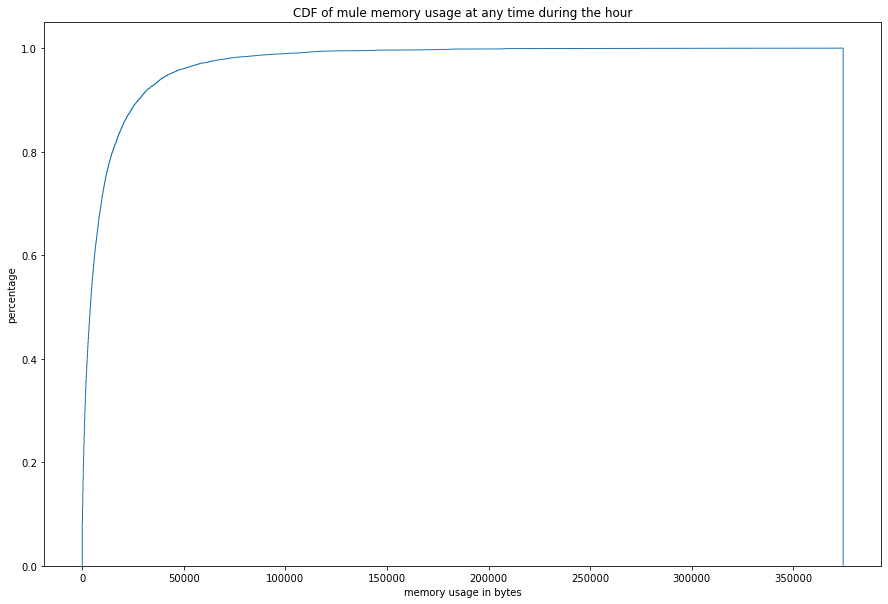

In [24]:
biggest_size = np.max(memory_usage)
num_bins = math.ceil(biggest_size/packet_size)
m_edges = [m * packet_size for m in range(num_bins + 1)]

plt.figure(figsize=(15,10))
plt.hist(memory_usage.reshape((-1)), bins=m_edges, density=True, cumulative=True, histtype='step')
plt.title('CDF of mule memory usage at any time during the hour')
plt.xlabel('memory usage in bytes')
plt.ylabel('percentage')
plt.show()

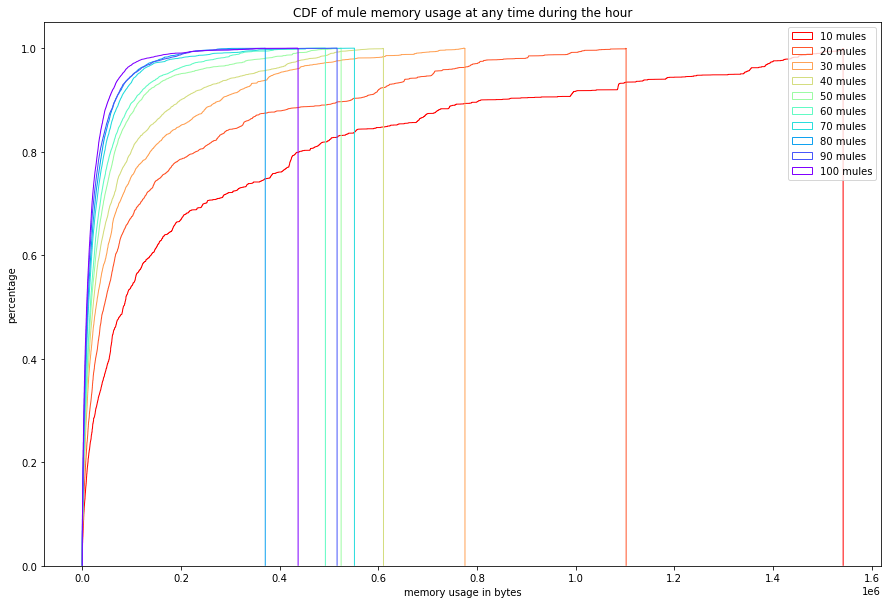

In [29]:
# Do the same thing with multiple number of mules
num_mules_list = [10, 20, 30, 40, 50, 60, 70 ,80, 90, 100] # integer <= 100
schedule_file = 'prob_data/random_uploads/vary_mules/{}_mule_schedule.csv'
colors = cm.rainbow(np.linspace(1, 0, len(num_mules_list)))
t_grain = 2.0
packet_size = 128
num_time_steps = math.ceil(3600/t_grain) # only look at the hour

plt.figure(figsize=(15,10))

for color_ind, num_mules in enumerate(num_mules_list):
    schedule_df = pd.read_csv(schedule_file.format(num_mules), skiprows=3)
    memory_usage = np.zeros((num_mules, num_time_steps)) # in batched case (units of number of packets)

    # Calculate memory usage.
    for index, row in schedule_df.iterrows():
        mule_id = int(row['mule_id'])
        pickup_time = row['pickup_time']
        batch_time = row['batch_time']
        start_ind = math.floor(pickup_time/t_grain)
        end_ind = math.ceil(batch_time/t_grain)

        memory_usage[mule_id, start_ind:end_ind] += 1
    
    memory_usage *= packet_size
    
    biggest_size = np.max(memory_usage)
    num_bins = math.ceil(biggest_size/packet_size)
    m_edges = [m * packet_size for m in range(num_bins + 1)]
    plt.hist(memory_usage.reshape((-1)), bins=m_edges, density=True, cumulative=True, histtype='step', color=colors[color_ind], label="{} mules".format(num_mules))

plt.legend()
plt.title('CDF of mule memory usage at any time during the hour')
plt.xlabel('memory usage in bytes')
plt.ylabel('percentage')
plt.show()

Nice nice. That doesn't look too bad! Even with only 10 mules and large data dumps each time a mule sees a sensor, there's a max of 1.6 MB of memory used on each mule, which is not terrible.

## Connections

Now we check the number of BLE connections each mule has at any time. For phones, I believe this number is capped at 8 BLE connections, so hopefully the max number is around there.

In [33]:
t_grain = 2.0
num_mules = 100
num_time_steps = math.ceil(3600/t_grain) # only look at the hour
sample_period = 10.0

In [34]:
schedule_file = 'prob_data/random_uploads/schedule.csv'
schedule_df = pd.read_csv(schedule_file, skiprows=3)
schedule_df = schedule_df.sort_values(['sensor_id', 'sample_time'])
schedule_df.head()

,sensor_id,mule_id,sample_time,pickup_time,batch_time,data_length
99898,0,39,0.0,117.501024,165,128
99899,0,39,10.0,117.502048,165,128
99900,0,39,20.0,117.503072,165,128
99901,0,39,30.0,117.504096,165,128
99902,0,39,40.0,117.505120,165,128


In [43]:
# Any gap in pickup times that is more than 1.5 times the sample period is a break in connection
time_threshold = 1.5 * sample_period
start_time = None
end_time = None
cur_mule = None
cur_sensor = None
connections = np.zeros((num_mules, num_time_steps)) # for both naive and batched

# Calculate connections.
for index, row in schedule_df.iterrows():
    new_mule = int(row['mule_id'])
    new_sensor = int(row['sensor_id'])
    pickup_time = row['pickup_time']
    
    # Instantiate for the first connection
    if start_time is None:
        start_time = pickup_time
        end_time = pickup_time
        cur_mule = new_mule
        cur_sensor = new_sensor
        continue
    
    # If we are in the same connection, continue
    if cur_mule == new_mule and cur_sensor == new_sensor and pickup_time - end_time < time_threshold:
        end_time = pickup_time
        continue
    
    # Otherwise, we reached the end of our connection, so we record the interaction and reset our bookkeeping
    start_ind = math.floor(start_time/t_grain)
    end_ind = math.ceil(end_time/t_grain)
    connections[cur_mule, start_ind:end_ind] += 1
    
    cur_mule = new_mule
    cur_sensor = new_sensor
    start_time = pickup_time
    end_time = pickup_time

# Wrap up the last connection
start_ind = math.floor(start_time/t_grain)
end_ind = math.ceil(end_time/t_grain)
connections[cur_mule, start_ind:end_ind] += 1

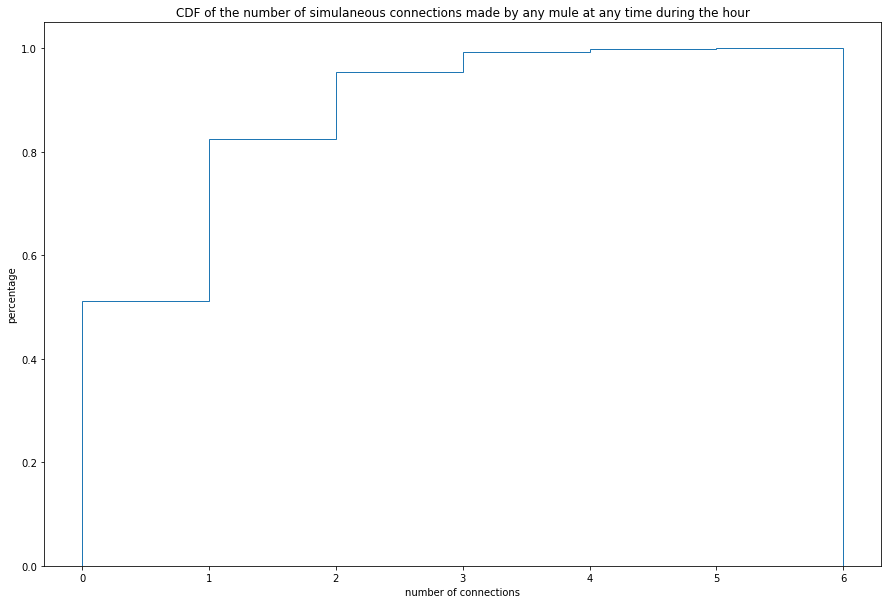

In [44]:
num_bins = int(np.max(connections))
c_edges = [c for c in range(num_bins + 1)]

plt.figure(figsize=(15,10))
plt.hist(connections.reshape((-1)), bins=c_edges, density=True, cumulative=True, histtype='step')
plt.title('CDF of the number of simulaneous connections made by any mule at any time during the hour')
plt.xlabel('number of connections')
plt.ylabel('percentage')
plt.show()

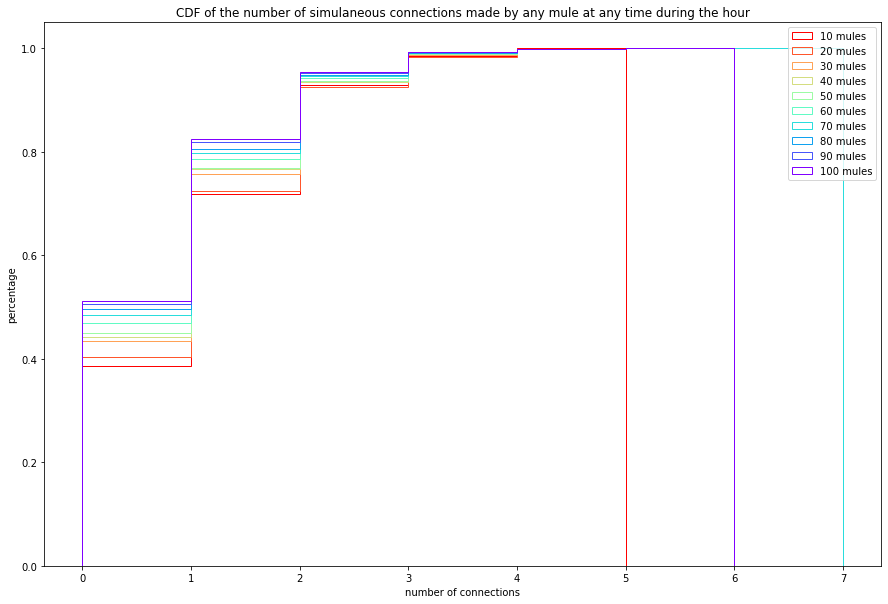

In [47]:
# Do the same thing with multiple number of mules
num_mules_list = [10, 20, 30, 40, 50, 60, 70 ,80, 90, 100] # integer <= 100
schedule_file = 'prob_data/random_uploads/vary_mules/{}_mule_schedule.csv'
colors = cm.rainbow(np.linspace(1, 0, len(num_mules_list)))
t_grain = 2.0
sample_period = 10.0
time_threshold = 1.5 * sample_period
num_time_steps = math.ceil(3600/t_grain) # only look at the hour
connections = np.zeros((num_mules, num_time_steps)) # for both naive and batchednum_time_steps = math.ceil(3600/t_grain) # only look at the hour

plt.figure(figsize=(15,10))

for color_ind, num_mules in enumerate(num_mules_list):
    schedule_df = pd.read_csv(schedule_file.format(num_mules), skiprows=3)
    schedule_df = schedule_df.sort_values(['sensor_id', 'sample_time'])
    connections = np.zeros((num_mules, num_time_steps))
    
    start_time = None
    end_time = None
    cur_mule = None
    cur_sensor = None

    # Calculate connections.
    for index, row in schedule_df.iterrows():
        new_mule = int(row['mule_id'])
        new_sensor = int(row['sensor_id'])
        pickup_time = row['pickup_time']

        # Instantiate for the first connection
        if start_time is None:
            start_time = pickup_time
            end_time = pickup_time
            cur_mule = new_mule
            cur_sensor = new_sensor
            continue

        # If we are in the same connection, continue
        if cur_mule == new_mule and cur_sensor == new_sensor and pickup_time - end_time < time_threshold:
            end_time = pickup_time
            continue

        # Otherwise, we reached the end of our connection, so we record the interaction and reset our bookkeeping
        start_ind = math.floor(start_time/t_grain)
        end_ind = math.ceil(end_time/t_grain)
        connections[cur_mule, start_ind:end_ind] += 1

        cur_mule = new_mule
        cur_sensor = new_sensor
        start_time = pickup_time
        end_time = pickup_time

    # Wrap up the last connection
    start_ind = math.floor(start_time/t_grain)
    end_ind = math.ceil(end_time/t_grain)
    connections[cur_mule, start_ind:end_ind] += 1
    
    num_bins = int(np.max(connections))
    c_edges = [c for c in range(num_bins + 1)]
    plt.hist(connections.reshape((-1)), bins=c_edges, density=True, cumulative=True, histtype='step', color=colors[color_ind], label="{} mules".format(num_mules))

plt.legend()
plt.title('CDF of the number of simulaneous connections made by any mule at any time during the hour')
plt.xlabel('number of connections')
plt.ylabel('percentage')
plt.show()

## Connection lengths

I'm curious how long each mule is actually connected to a sensor.

In [48]:
schedule_file = 'prob_data/random_uploads/schedule.csv'
schedule_df = pd.read_csv(schedule_file, skiprows=3)
schedule_df = schedule_df.sort_values(['sensor_id', 'sample_time'])
schedule_df.head()

,sensor_id,mule_id,sample_time,pickup_time,batch_time,data_length
99898,0,39,0.0,117.501024,165,128
99899,0,39,10.0,117.502048,165,128
99900,0,39,20.0,117.503072,165,128
99901,0,39,30.0,117.504096,165,128
99902,0,39,40.0,117.505120,165,128


In [49]:
sample_period = 10.0
time_threshold = 1.5 * sample_period

connection_lengths = []

start_time = None
end_time = None
cur_mule = None
cur_sensor = None

# Calculate connections.
for index, row in schedule_df.iterrows():
    new_mule = int(row['mule_id'])
    new_sensor = int(row['sensor_id'])
    pickup_time = row['pickup_time']

    # Instantiate for the first connection
    if start_time is None:
        start_time = pickup_time
        end_time = pickup_time
        cur_mule = new_mule
        cur_sensor = new_sensor
        continue

    # If we are in the same connection, continue
    if cur_mule == new_mule and cur_sensor == new_sensor and pickup_time - end_time < time_threshold:
        end_time = pickup_time
        continue

    # Otherwise, we reached the end of our connection, so we record the interaction and reset our bookkeeping
    connection_lengths.append(end_time - start_time)

    cur_mule = new_mule
    cur_sensor = new_sensor
    start_time = pickup_time
    end_time = pickup_time

# Wrap up the last connection
connection_lengths.append(end_time - start_time)

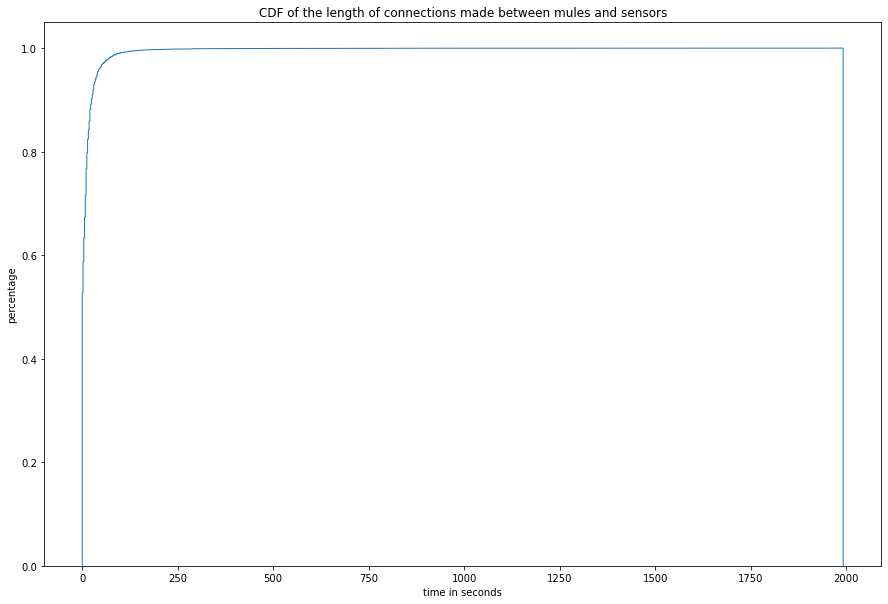

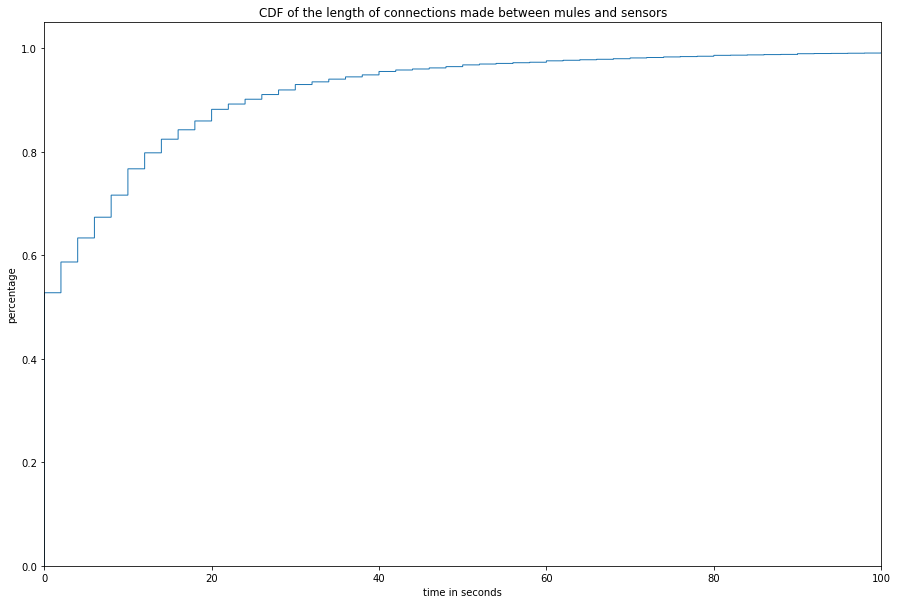

In [51]:
longest_connection_time = max(connection_lengths)
t_grain = 2.0
num_bins = math.ceil(longest_connection_time / t_grain)
t_edges = [t * t_grain for t in range(num_bins + 1)]

plt.figure(figsize=(15,10))
plt.hist(connection_lengths, bins=t_edges, density=True, cumulative=True, histtype='step')
plt.title('CDF of the length of connections made between mules and sensors')
plt.xlabel('time in seconds')
plt.ylabel('percentage')
plt.show()

plt.figure(figsize=(15,10))
plt.hist(connection_lengths, bins=t_edges, density=True, cumulative=True, histtype='step')
plt.title('CDF of the length of connections made between mules and sensors')
plt.xlabel('time in seconds')
plt.ylabel('percentage')
plt.xlim(0, 100)
plt.show()

## Interaction lengths

Seems like half of these connections are just long enough to dump accumulated files and dip, which means they just have to be over, like, a 5 second interaction. I'm curious how long interactions usually are...

In [52]:
interaction_file = 'prob_data/interactions.csv'
interaction_df = pd.read_csv(interaction_file)
interaction_df.head()

,sensor_id,mule_id,interaction_time,interaction_duration
0,546,0,0.0,1.3
1,697,0,0.0,2.7
2,977,0,0.0,6.7
3,638,0,4.6,3.5
4,624,0,1.2,8.7


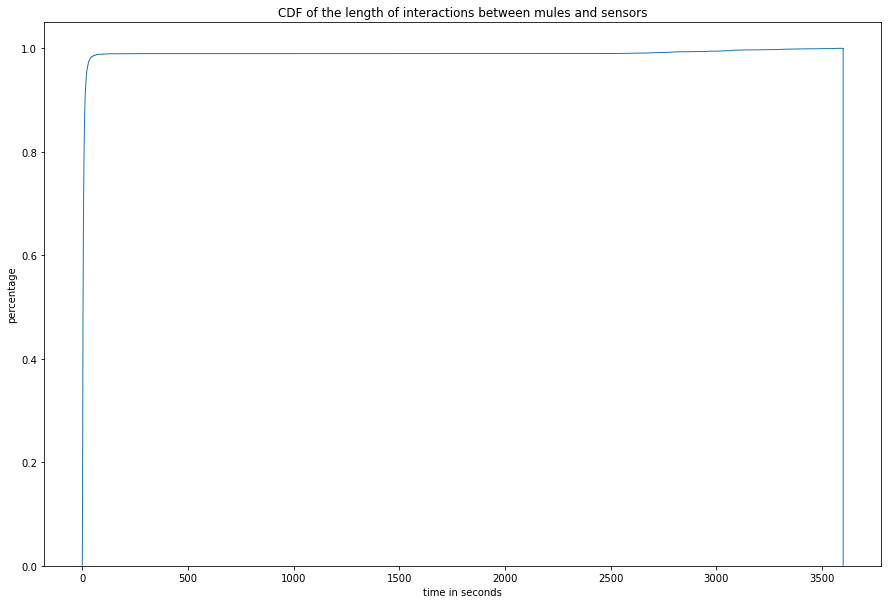

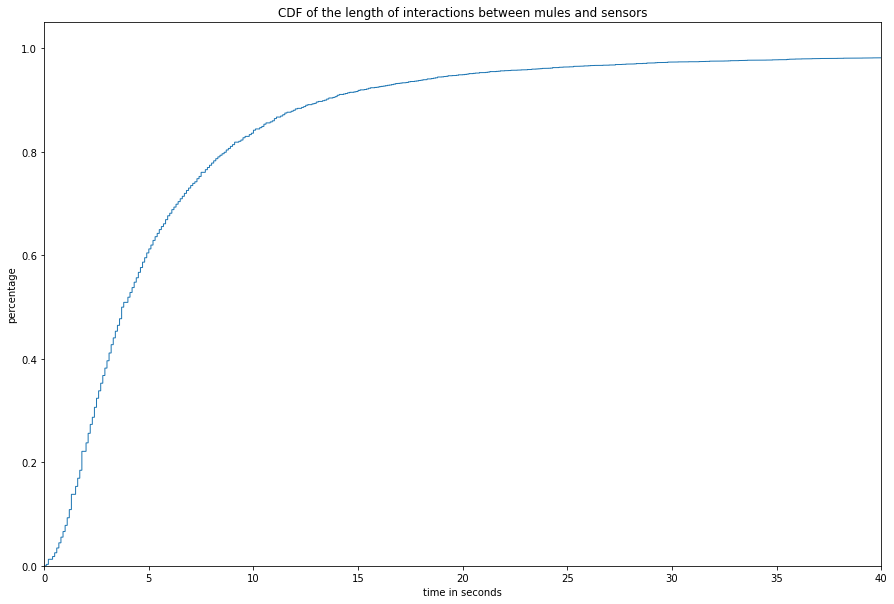

In [62]:
longest_interaction = interaction_df['interaction_duration'].max()
t_grain = 0.1
num_bins = math.ceil(longest_interaction / t_grain)
t_edges = [t * t_grain for t in range(num_bins + 1)]

plt.figure(figsize=(15,10))
plt.hist(interaction_df['interaction_duration'], bins=t_edges, density=True, cumulative=True, histtype='step')
plt.title('CDF of the length of interactions between mules and sensors')
plt.xlabel('time in seconds')
plt.ylabel('percentage')
plt.show()

plt.figure(figsize=(15,10))
plt.hist(interaction_df['interaction_duration'], bins=t_edges, density=True, cumulative=True, histtype='step')
plt.title('CDF of the length of interactions between mules and sensors')
plt.xlabel('time in seconds')
plt.ylabel('percentage')
plt.xlim(0, 40)
plt.show()

Ok, honestly, an interaction of 3600 seconds seems really suspicious... Not entirely sure what's going on there...

In [55]:
interaction_df.loc[interaction_df['interaction_duration'] == 3600]

,sensor_id,mule_id,interaction_time,interaction_duration
4344,902,46,0.0,3600.0
7915,55,78,0.0,3600.0
7916,113,78,0.0,3600.0
7917,712,78,0.0,3600.0
8293,299,84,0.0,3600.0


Mmm... I guess they just spawned somewhere nice and didn't manage to get out?

In [59]:
interaction_df.loc[(interaction_df['mule_id'] == 46) |
                   (interaction_df['mule_id'] == 78) |
                   (interaction_df['mule_id'] == 84)]

,sensor_id,mule_id,interaction_time,interaction_duration
4344,902,46,0.0,3600.0
7915,55,78,0.0,3600.0
7916,113,78,0.0,3600.0
7917,712,78,0.0,3600.0
8267,132,84,3.4,35.5
8268,132,84,39.7,28.6
8269,132,84,69.1,45.1
8270,132,84,115.8,36.4
8271,132,84,154.4,21.9
8272,132,84,179.6,62.8


Yeah. Looks like 84 was jumping in and out of the range of 132 but all three of these people stayed about the same place.